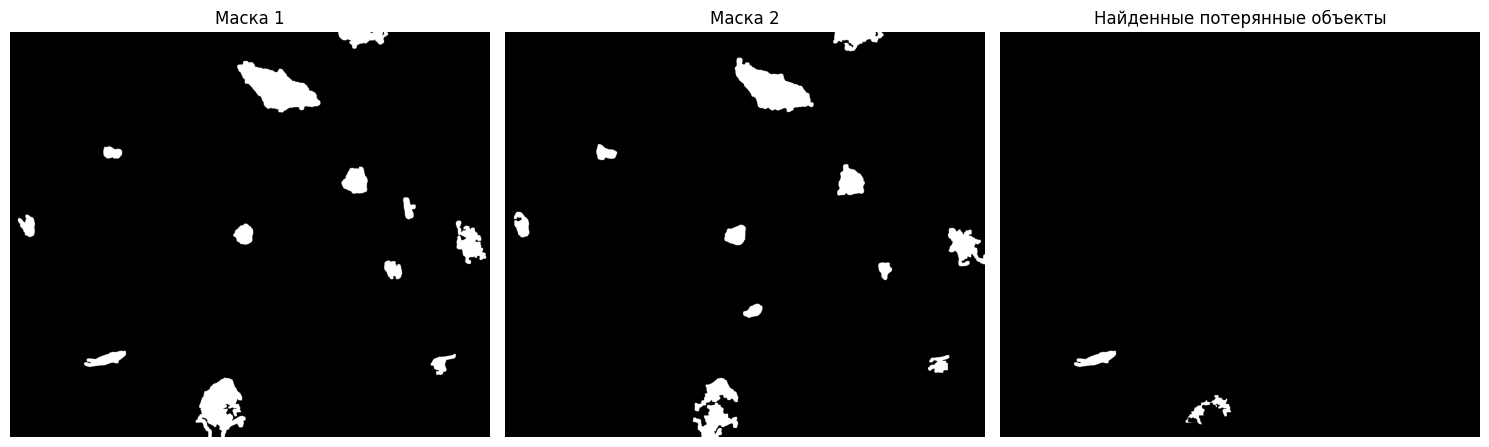

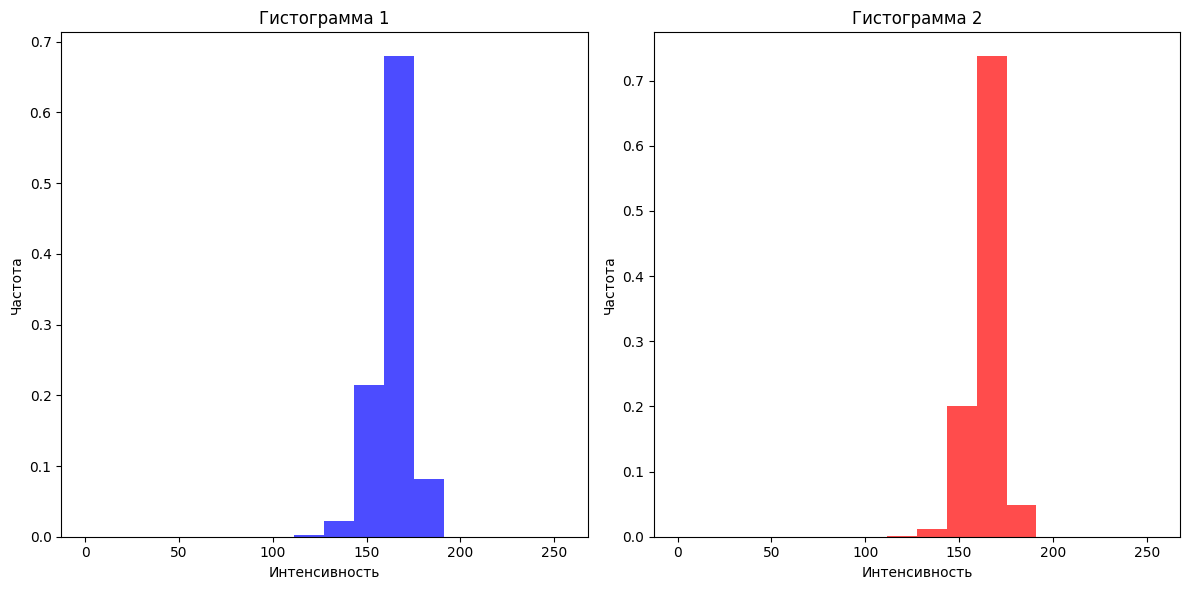

Объект 1: p-value Хи-квадрат = 1.0000, Колмогоров-Смирнов = 0.0000


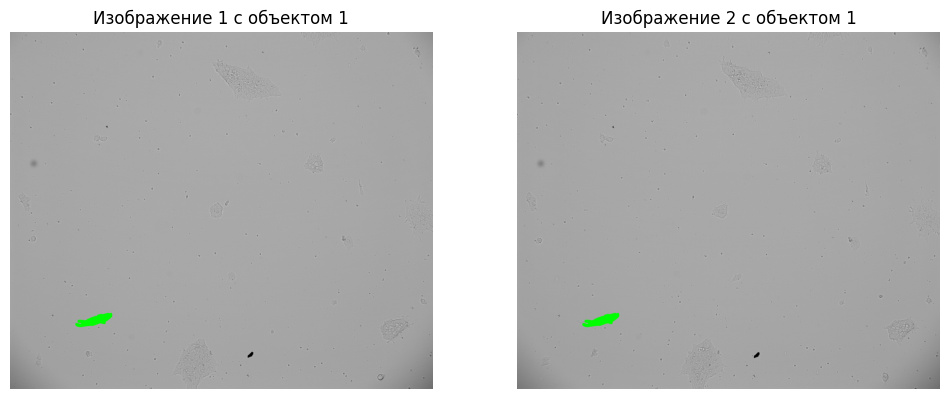

Таблица пикселей и интенсивностей для объекта 1:
Объект 1 (Y, X)  Интенсивность 1 Объект 2 (Y, X)  Интенсивность 2  Разница интенсивностей
     (1700,588)              167      (1700,588)              166                       1
     (1700,589)              164      (1700,589)              167                       3
     (1700,590)              167      (1700,590)              164                       3
     (1700,591)              169      (1700,591)              161                       8
     (1700,592)              167      (1700,592)              166                       1
     (1700,593)              167      (1700,593)              166                       1
     (1700,594)              166      (1700,594)              167                       1
     (1700,595)              166      (1700,595)              166                       0
     (1700,596)              166      (1700,596)              164                       2
     (1700,597)              167      (1700,597)   

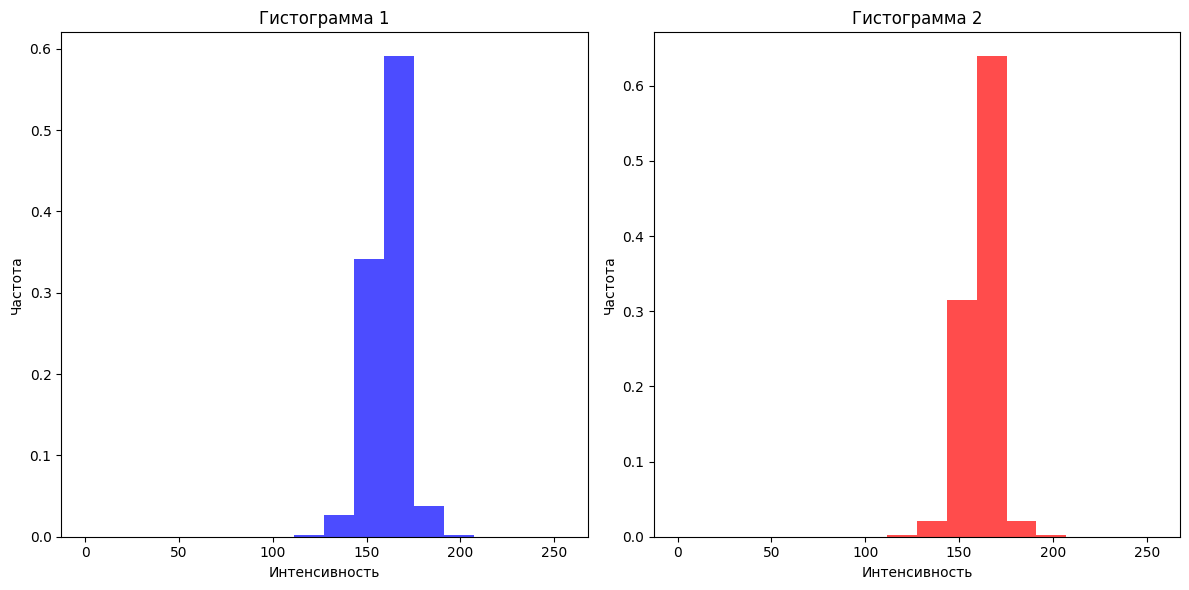

Объект 2: p-value Хи-квадрат = 1.0000, Колмогоров-Смирнов = 0.0000


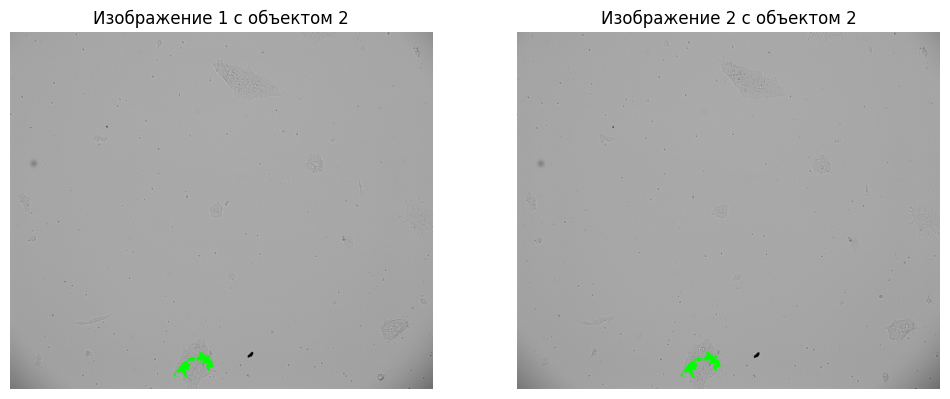

Таблица пикселей и интенсивностей для объекта 2:
Объект 1 (Y, X)  Интенсивность 1 Объект 2 (Y, X)  Интенсивность 2  Разница интенсивностей
    (1936,1145)              143     (1936,1145)              161                      18
    (1936,1146)              147     (1936,1146)              161                      14
    (1936,1147)              154     (1936,1147)              163                       9
    (1936,1158)              158     (1936,1158)              160                       2
    (1936,1159)              154     (1936,1159)              166                      12
    (1936,1160)              157     (1936,1160)              167                      10
    (1936,1161)              160     (1936,1161)              169                       9
    (1937,1144)              158     (1937,1144)              158                       0
    (1937,1145)              155     (1937,1145)              167                      12
    (1937,1146)              152     (1937,1146)   

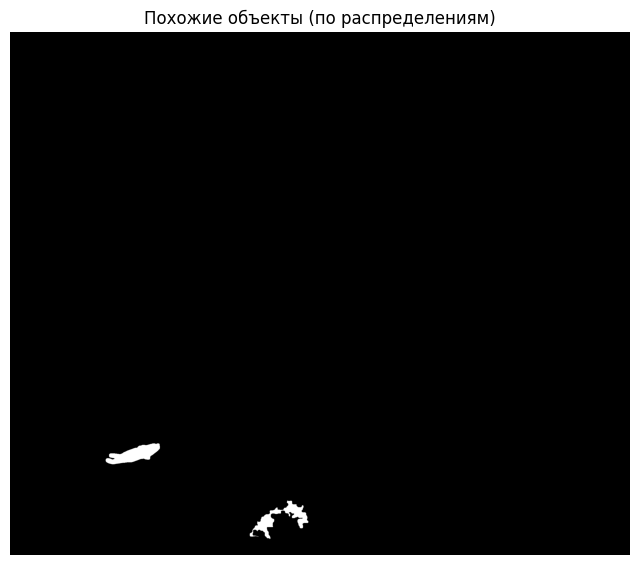

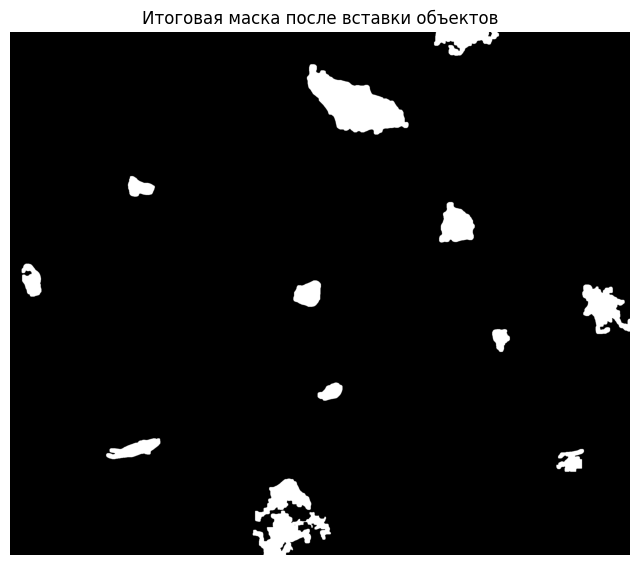

Готово! Маски сохранены.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Для отображения изображений
from typing import List, Tuple
from scipy import ndimage  # Для поиска связных областей на изображениях
from scipy.stats import chisquare, ks_2samp  # Статистические тесты
from skimage.registration import phase_cross_correlation  # Оценка сдвига между изображениями
import argparse
import os

# Функция для чтения маски изображения и её бинаризации
def read_mask(path: str) -> np.ndarray:
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Чтение в градациях серого
    if mask is None:
        raise FileNotFoundError(f"Не удалось загрузить маску из файла: {path}")
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)  # Бинаризация маски
    return binary

# Функция для чтения обычного серого изображения
def read_gray(path: str) -> np.ndarray:
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение: {path}")
    return gray

# Функция для отображения изображения через matplotlib
def show_image(title: str, image: np.ndarray) -> None:
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Функция для поиска потерянных объектов между двумя масками
def find_lost_objects(
    mask1: np.ndarray,
    mask2: np.ndarray,
    min_pixels: int
) -> List[np.ndarray]:
    diff = cv2.subtract(mask1, mask2)  # Вычитание масок
    _, diff_binary = cv2.threshold(diff, 127, 255, cv2.THRESH_BINARY)  # Бинаризация разницы
    labeled_array, num_features = ndimage.label(diff_binary)  # Нахождение объектов
    objects: List[np.ndarray] = []
    for i in range(1, num_features + 1):
        coords = np.argwhere(labeled_array == i)  # Координаты каждого объекта
        if coords.shape[0] >= min_pixels:  # Фильтрация по минимальному размеру
            objects.append(coords)
    return objects

# Функция для извлечения яркостей пикселей объекта из серого изображения
def extract_intensity_distribution(
    gray: np.ndarray,
    object_pixels: np.ndarray
) -> np.ndarray:
    return gray[object_pixels[:, 0], object_pixels[:, 1]]

# Функция для сравнения распределений яркостей двух объектов
def compare_distributions(
    intensities1: np.ndarray,
    intensities2: np.ndarray,
    bins: int = 16
) -> Tuple[float, float]:
    # Создаем гистограммы для двух наборов интенсивностей
    hist1, bin_edges1 = np.histogram(intensities1, bins=bins, range=(0, 255))  # Гистограмма 1
    hist2, bin_edges2 = np.histogram(intensities2, bins=bins, range=(0, 255))  # Гистограмма 2
    
    # Добавление малого числа для избежания деления на ноль
    hist1 = hist1 + 1e-6
    hist2 = hist2 + 1e-6
    
    # Нормализуем гистограммы для лучшего визуального сравнения
    hist1 = hist1 / hist1.sum()
    hist2 = hist2 / hist2.sum()

    # Визуализация гистограмм рядом друг с другом
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Гистограмма 1
    axes[0].bar(bin_edges1[:-1], hist1, width=np.diff(bin_edges1), align='edge', color='blue', alpha=0.7)
    axes[0].set_title('Гистограмма 1')
    axes[0].set_xlabel('Интенсивность')
    axes[0].set_ylabel('Частота')

    # Гистограмма 2
    axes[1].bar(bin_edges2[:-1], hist2, width=np.diff(bin_edges2), align='edge', color='red', alpha=0.7)
    axes[1].set_title('Гистограмма 2')
    axes[1].set_xlabel('Интенсивность')
    axes[1].set_ylabel('Частота')

    # Показываем графики
    plt.tight_layout()
    plt.show()

    # Хи-квадрат тест для сравнения распределений
    chi_stat, chi_p = chisquare(f_obs=hist1, f_exp=hist2)

    # Тест Колмогорова-Смирнова для сравнения интенсивностей
    ks_stat, ks_p = ks_2samp(np.float16(intensities1)/255, np.float16(intensities2)/255)

    return chi_p, ks_p  # Возвращаем p-value для обоих тестов

# Функция для создания маски по списку объектов
def generate_mask_from_objects(
    shape: Tuple[int, int],
    objects: List[np.ndarray]
) -> np.ndarray:
    mask = np.zeros(shape, dtype=np.uint8)  # Пустая маска
    for obj in objects:
        mask[obj[:, 0], obj[:, 1]] = 255  # Заполнение пикселей объекта
    return mask

# Функция для вычисления ограничивающего прямоугольника объекта
def extract_bounding_box(
    pixels: np.ndarray,
    margin: int = 5
) -> Tuple[int, int, int, int]:
    ys = pixels[:, 0]
    xs = pixels[:, 1]
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()
    return (y_min - margin, y_max + margin, x_min - margin, x_max + margin)

# Функция для нахождения сдвига объекта с помощью автокорреляции (кросс корелляция фазовая)
def autocorrelation_shift(
    template: np.ndarray,
    search_area: np.ndarray
) -> Tuple[int, int]:
    shift, _, _ = phase_cross_correlation(search_area, template, upsample_factor=10)  # Оценка сдвига
    shift_y, shift_x = int(round(shift[0])), int(round(shift[1]))  # Округление до целых
    return shift_y, shift_x

# Функция для вставки объекта в новую маску с учётом сдвига
def insert_object(
    base_mask: np.ndarray,
    object_pixels: np.ndarray,
    shift_y: int,
    shift_x: int
) -> np.ndarray:
    new_mask = base_mask.copy()
    h, w = base_mask.shape
    for y, x in object_pixels:
        new_y = y + shift_y
        new_x = x + shift_x
        # Проверка на выход за границы изображения
        if 0 <= new_y < h and 0 <= new_x < w:
            if new_mask[new_y, new_x] == 0:  # Только если пиксель пуст
                new_mask[new_y, new_x] = 255
    return new_mask

import pandas as pd

def draw_objects_on_image(image: np.ndarray, objects: List[np.ndarray]) -> np.ndarray:
    """Рисует объекты на сером изображении."""
    image_with_objects = image.copy()  # Создаём копию изображения, чтобы не изменить оригинал
    for obj in objects:
        # Конвертируем координаты объектов в контуры для рисования
        contour = obj.reshape((-1, 1, 2)).astype(np.int32)  # Преобразуем в нужный формат для рисования
        cv2.drawContours(image_with_objects, [contour], -1, (255), 1)  # Рисуем контуры объектов (цвет 255 для белого)
    return image_with_objects

# Добавление функции для отображения изображений рядом
def show_images_side_by_side(image1: np.ndarray, image2: np.ndarray, title1: str, title2: str) -> None:
    """Отображает два изображения рядом."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title(title1)
    axes[0].axis('off')
    
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title(title2)
    axes[1].axis('off')
    
    plt.show()

# Функция для рисования объектов на изображении
def draw_objects_on_image(image: np.ndarray, objects: List[np.ndarray]) -> np.ndarray:
    """Отображает объекты на изображении, выделяя их зеленым цветом."""
    image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Конвертируем в цветное изображение (RGB)
    for obj in objects:
        for y, x in obj:
            image_copy[y, x] = [0, 255, 0]  # Зеленый цвет на изображении
    return image_copy

def display_pixel_table_with_intensity(
    obj1: np.ndarray, 
    obj2: np.ndarray, 
    gray1: np.ndarray, 
    gray2: np.ndarray, 
    object_idx: int
) -> None:
    """Отображает таблицу с координатами пикселей, интенсивностями и разницей интенсивностей для двух объектов."""
    
    # Проверяем, что количество объектов одинаковое
    if len(obj1) != len(obj2):
        print("Ошибка: количество пикселей в объектах obj1 и obj2 не совпадает.")
        return
    
    # Получаем интенсивности для каждого объекта на обоих изображениях
    intensities1 = gray1[obj1[:, 0], obj1[:, 1]]
    intensities2 = gray2[obj2[:, 0], obj2[:, 1]]
    
    # Вычисляем разницу интенсивностей для каждого пикселя
    intensity_diff = []
    for i in range(len(intensities1)):
        diff = abs(int(intensities1[i]) - int(intensities2[i]))
        intensity_diff.append(diff)
   
    # Настройка отображения, чтобы вся таблица помещалась на экране
    pd.set_option('display.max_columns', None)  # Не ограничивать количество столбцов
    pd.set_option('display.width', None)  # Отключить ограничение по ширине
    # Создаем DataFrame с четырьмя колонками: координаты, интенсивности и разница
    df = pd.DataFrame({
        "Объект 1 (Y, X)": [f"({y},{x})" for y, x in obj1],
        "Интенсивность 1": intensities1,
        "Объект 2 (Y, X)": [f"({y},{x})" for y, x in obj2],
        "Интенсивность 2": intensities2,
        "Разница интенсивностей": intensity_diff
    })
    
    # Выводим таблицу без переноса столбцов
    print(f"Таблица пикселей и интенсивностей для объекта {object_idx + 1}:")
    print(df.to_string(index=False))  # Печать таблицы без индексов
    print()  # Для пустой строки между выводами
    # Функция для отображения изображений рядом
    
def show_images_side_by_side_mask(mask1, mask2, lost_mask):
    # Создаем фигуру с тремя субплотами
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Отображаем Маску 1
    axes[0].imshow(mask1, cmap='gray')
    axes[0].set_title('Маска 1')
    axes[0].axis('off')  # Отключаем оси

    # Отображаем Маску 2
    axes[1].imshow(mask2, cmap='gray')
    axes[1].set_title('Маска 2')
    axes[1].axis('off')

    # Отображаем Найденные потерянные объекты
    axes[2].imshow(lost_mask, cmap='gray')
    axes[2].set_title('Найденные потерянные объекты')
    axes[2].axis('off')

    # Показываем изображения
    plt.tight_layout()
    plt.show()

# --------------------------
# Функция логирования
# --------------------------
def log_analysis(
    log_path: str,
    object_idx: int,
    coords: np.ndarray,
    chi_p: float,
    ks_p: float,
    shift_y: int = None,
    shift_x: int = None
) -> None:
    center_y = int(coords[:, 0].mean())
    center_x = int(coords[:, 1].mean())
    with open(log_path, "a") as f:
        f.write(f"Объект {object_idx + 1}:\n")
        f.write(f" - Центр: ({center_y}, {center_x})\n")
        f.write(f" - p-value Хи-квадрат: {chi_p:.4f}\n")
        f.write(f" - p-value Колмогоров-Смирнов: {ks_p:.4f}\n")
        if shift_y is not None and shift_x is not None:
            f.write(f" - Сдвиг (dy, dx): ({shift_y}, {shift_x})\n")
        f.write("-" * 40 + "\n")

def parse_arguments():
    parser = argparse.ArgumentParser(description="Анализ изображений и масок.")
    parser.add_argument('--min_pixels', type=int, default=5000, help='Минимальный размер объекта (в пикселях)')
    parser.add_argument('--chi_threshold', type=float, default=0.05, help='Порог p-value для теста Хи-квадрат')
    parser.add_argument('--ks_threshold', type=float, default=0.05, help='Порог p-value для теста Колмогорова-Смирнова')
    parser.add_argument('--input_dir', type=str, required=True, help='Путь к директории с изображениями и масками')
    return parser.parse_args()

def get_image_pairs(directory):
    files = sorted(os.listdir(directory))
    mask_files = [f for f in files if f.endswith('_mask.tif')]
    gray_files = [f for f in files if f.endswith('_lum.tif')]

    pairs = []
    for i in range(len(mask_files) - 1):
        mask1 = os.path.join(directory, mask_files[i])
        mask2 = os.path.join(directory, mask_files[i + 1])
        gray1 = os.path.join(directory, gray_files[i])
        gray2 = os.path.join(directory, gray_files[i + 1])
        pairs.append((mask1, mask2, gray1, gray2))
    return pairs

def main() -> None:
    # args = parse_arguments()
    # min_pixels = args.min_pixels
    # chi_threshold = args.chi_threshold
    # ks_threshold = args.ks_threshold
    # input_dir = args.input_dir
    # args = parse_arguments()
    # pairs = get_image_pairs(args.input_dir)
    # for mask1_path, mask2_path, gray1_path, gray2_path in pairs:
    #     # Загрузка изображений и масок
    #     mask1 = read_mask(mask1_path)
    #     mask2 = read_mask(mask2_path)
    #     gray1 = read_gray(gray1_path)
    #     gray2 = read_gray(gray2_path)
    # # Очистить лог перед началом
    # open("analysis_log.txt", "w").close()
    # Пути к файлам
    mask1_path = '2_mask.tif'
    mask2_path = '3_mask.tif'
    gray1_path = '2_lum.tif'
    gray2_path = '3_lum.tif'

    # Загрузка масок и серых изображений
    mask1 = read_mask(mask1_path)
    mask2 = read_mask(mask2_path)
    gray1 = read_gray(gray1_path)
    gray2 = read_gray(gray2_path)

    # Отображаем маски
    #show_image('Маска 1', mask1)
    #show_image('Маска 2', mask2)

    # Найти потерянные объекты
    lost_objects = find_lost_objects(mask1, mask2, min_pixels=5000)

    # Генерация маски для потерянных объектов
    lost_mask = generate_mask_from_objects(mask1.shape, lost_objects)
    #show_image('Найденные потерянные объекты', lost_mask)
    show_images_side_by_side_mask(mask1, mask2, lost_mask)
    # Сравнение распределений

    # Сравнение распределений
    similar_objects: List[np.ndarray] = []
    for idx, obj in enumerate(lost_objects):
        intensities1 = extract_intensity_distribution(gray1, obj)
        intensities2 = extract_intensity_distribution(gray2, obj)

        chi_p, ks_p = compare_distributions(intensities1, intensities2)

        print(f'Объект {idx + 1}: p-value Хи-квадрат = {chi_p:.4f}, Колмогоров-Смирнов = {ks_p:.4f}')

        # Отображаем серые изображения с обведёнными объектами рядом
        gray1_with_objects = draw_objects_on_image(gray1, [obj])
        gray2_with_objects = draw_objects_on_image(gray2, [obj])

        # Выделяем проверяемые пиксели на изображении зеленым цветом
        for y, x in obj:
            gray1_with_objects[y, x] = [0, 255, 0]  # Зеленый цвет на изображении 1
            gray2_with_objects[y, x] = [0, 255, 0]  # Зеленый цвет на изображении 2

        show_images_side_by_side(gray1_with_objects, gray2_with_objects, f'Изображение 1 с объектом {idx + 1}', f'Изображение 2 с объектом {idx + 1}')

        # Выводим таблицу с координатами и интенсивностями для объекта на обоих изображениях
        display_pixel_table_with_intensity(obj, obj, gray1, gray2, idx)

        # Если объекты похожи по распределению, добавляем их в список похожих объектов
        if chi_p > 0.05 or ks_p > 0.05:
            similar_objects.append(obj)

    # Генерация маски для похожих объектов
    similar_mask = generate_mask_from_objects(mask1.shape, similar_objects)
    show_image('Похожие объекты (по распределениям)', similar_mask)

    # Сдвиги объектов по автокорреляции (кросс корелляции)
    result_mask = mask2.copy()
    for obj in similar_objects:
        y_min, y_max, x_min, x_max = extract_bounding_box(obj, margin=10)
        y_min = max(0, y_min)
        y_max = min(result_mask.shape[0], y_max)
        x_min = max(0, x_min)
        x_max = min(result_mask.shape[1], x_max)

        template = np.zeros_like(result_mask)
        template[obj[:, 0], obj[:, 1]] = 255
        template_crop = template[y_min:y_max, x_min:x_max]
        search_area = gray2[y_min:y_max, x_min:x_max]

        shift_y, shift_x = autocorrelation_shift(template_crop, search_area)

        result_mask = insert_object(result_mask, obj, shift_y, shift_x)

    show_image('Итоговая маска после вставки объектов', result_mask)

    # Сохранение результатов
    cv2.imwrite('lost_objects_mask.png', similar_mask)
    cv2.imwrite('final_result_mask.png', result_mask)
    print('Готово! Маски сохранены.')

# Точка входа программы
if __name__ == '__main__':
    main()